In [259]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from skimage.io import imread
from skimage.color import rgb2gray
from scipy import signal as sig
from scipy import ndimage

#### Exercice 1

tirez 100 vecteurs aléatoires v_i de taille D avec D qui va 1 à 1000 et pour valeur de D calculer y(D)= max_{i,j}( \| v_i - v_j\|^2)/min_{i,j}( \| v_i - v_j\|^2).
représentez la courbe y(D).

In [62]:
def exo_1 (D,n = 100):
    tir = np.random.rand(n,D)
    max_dist = 0
    min_dist = 1000
    for i in range (n-1):
        for j in range (i+1,n):
            if max_dist < (np.linalg.norm(tir[i]-tir[j]))**2:
                max_dist = (np.linalg.norm(tir[i]-tir[j]))**2
            elif min_dist > (np.linalg.norm(tir[i]-tir[j]))**2:
                min_dist = (np.linalg.norm(tir[i]-tir[j]))**2
                
    return(max_dist/min_dist)

In [80]:
Y_D = np.zeros(1000)
for k in range (1,1000):
    Y_D[k] = exo_1(k)

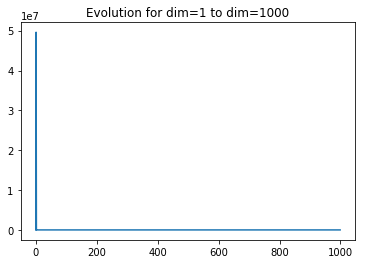

In [125]:
plt.title('Evolution for dim=1 to dim=1000')

plt.plot(Y_D)

plt.show()

I get rid off the first 10 values to see the result at a better scale.

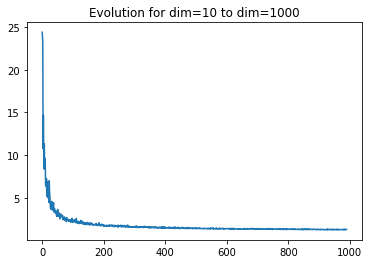

In [109]:
plt.title('Evolution for dim=10 to dim=1000')

plt.plot(Y_D[10:])

plt.show()

It is a practicle example of the "curse" of dimentionality and how it could make interpretation difficult.

#### Exercice 2

tirez 1000 vecteurs aléatoires v_i de R^3 dans une boule rayon 5. Réduire la dimension de cette boule pour passer a R^2 avec l'ACP et la kernel ACP avec diffèrent kernels.

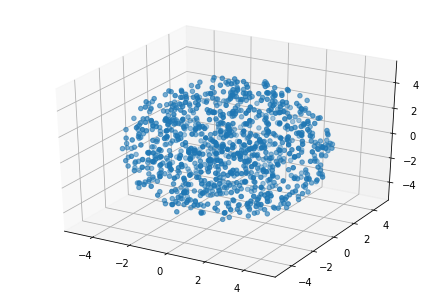

In [201]:
# Generate vectors:

tir = np.zeros((1000,3))
for i in range (1000):
    gauss = np.random.normal(size = 3)
    length = np.linalg.norm(gauss)
    if length == 0.0:
        tir[i] = gauss
    else:
        r = 5 * np.random.rand() ** (1/3)
        tir[i] = np.multiply(gauss, r/length)
        
# Original data
sequence_containing_x_vals = list(tir.transpose()[0])
sequence_containing_y_vals = list(tir.transpose()[1])
sequence_containing_z_vals = list(tir.transpose()[2])
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals,
           sequence_containing_z_vals)


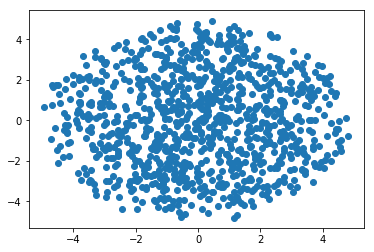

In [223]:
# PCA


# centering data

m = np.mean(tir, axis =0)
tir_centered = tir - m

# covariance matrix

tir_cov=np.cov(tir_centered.T)

# eigen decomposition

eigenvals, eigenvecs = np.linalg.eig(tir_cov)

# sorting

i= np.argsort(eigenvals)[::-1]
eigenvecs = eigenvecs[:,i]
eigenvals= eigenvals[i]

# applying PCA to go on R^2

X= np.dot(tir_centered,eigenvecs[:2].T)

# Plotting the transformation

plt.scatter(X.T[0],X.T[1])

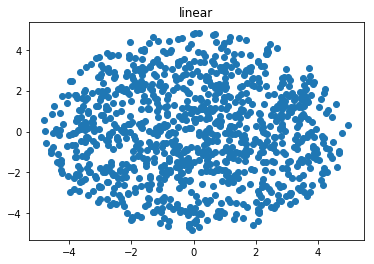

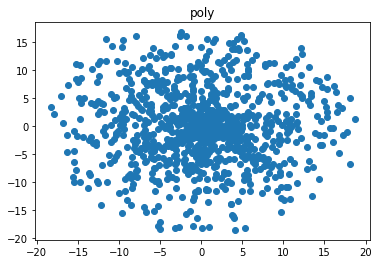

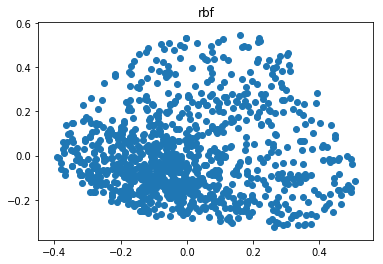

In [236]:
# Kernel PCA

for k in ['linear','poly','rbf']:
    transformer = KernelPCA(n_components=2, kernel=k)
    tir_transformed = transformer.fit_transform(tir)
    plt.title(k)
    plt.scatter(tir_transformed.T[0],tir_transformed.T[1])
    plt.show()

#### Exercice 3

Calculer les points de clef Harris dans les images lego et chessboard.

In [393]:
def harris_keypoints(path,alpha,size=1):
    '''
    Imputs:
    - path: Image path
    - alpha: coefficient between 0.04 and 0.06
    - size: size of the corners points
    
    Outputs:
    - original image
    - corner and edge detection
    - corner_response: the harris keypoints we found
    '''

    # Load image

    img = imread(path)
    img = img[:,:,0:3]
    imggray = rgb2gray(img)

    plt.imshow(imggray, cmap="gray")
    plt.axis("off")
    plt.show()

    # image derivatives

    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) 

    I_x = sig.convolve2d(imggray, kernel_x, mode='same')
    I_y = sig.convolve2d(imggray, kernel_y, mode='same')

    # Corners as distinctive interest points

    Ixx = ndimage.gaussian_filter(I_x**2, sigma=1)
    Ixy = ndimage.gaussian_filter(I_y*I_x, sigma=1)
    Iyy = ndimage.gaussian_filter(I_y**2, sigma=1)

    # Corner response function

    detA = Ixx * Iyy - Ixy ** 2

    traceA = Ixx + Iyy

    corner_response = detA - alpha * traceA ** 2

    img_copy_for_corners = np.copy(img)
    img_copy_for_edges = np.copy(img)

    for rowindex, response in enumerate(corner_response):
        for colindex, r in enumerate(response):
            if r > 0:
                # Corner
                img_copy_for_corners[rowindex-size:rowindex+size, colindex-size:colindex+size] = [255,0,0]
            elif r < 0:
                # Edge
                img_copy_for_edges[rowindex, colindex] = [0,255,0]
        
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
    ax[0].set_title("Corners")
    ax[0].imshow(img_copy_for_corners)
    ax[1].set_title("Edges")
    ax[1].imshow(img_copy_for_edges)
    plt.show()
    
    return(corner_response)

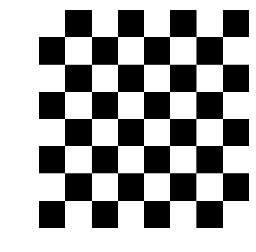

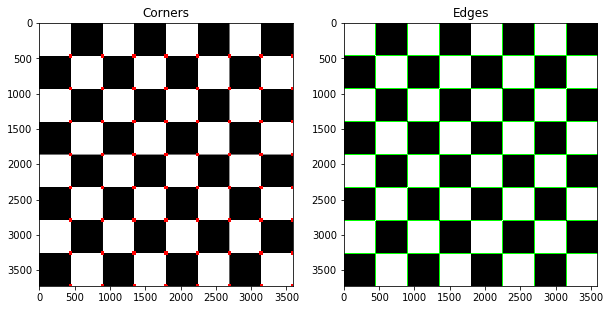

In [390]:
response = harris_keypoints('chessboard.png',0.05,20)

It is an ideal case with very easy corner to detect, let see how it will perform on a more realstic image.

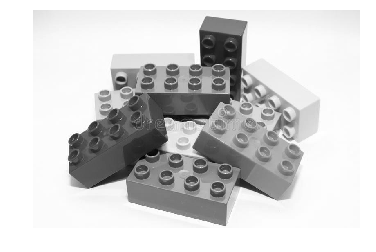

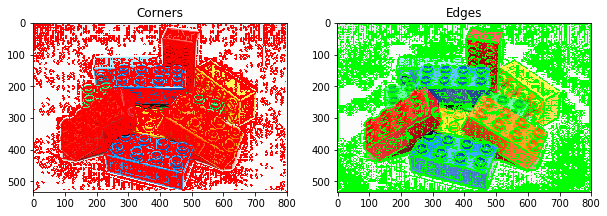

In [391]:
response = harris_keypoints('lego.jpg',0.05)

That's pretty bad, let's find local maxima to have a better result.

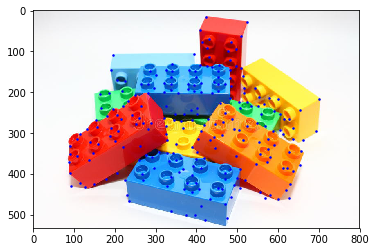

In [392]:
corners = corner_peaks(response, min_distance=10, threshold_rel=1e-6)
fig, ax = plt.subplots()
ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(corners[:, 1], corners[:, 0], '.b', markersize=3)

After finding good hyper-parameters, I get a "okay" result but hard to re-used in any configuration.